# Memory Agent

## Review

We created a chatbot that saves semantic memories to a single [user profile](https://langchain-ai.github.io/langgraph/concepts/memory/#profile) or [collection](https://langchain-ai.github.io/langgraph/concepts/memory/#collection).

We introduced [Trustcall](https://github.com/hinthornw/trustcall) as a way to update either schema.

## Goals

Now, we're going to pull together the pieces we've learned to build an [agent](https://langchain-ai.github.io/langgraph/concepts/agentic_concepts/) with long-term memory.

Our agent, `task_mAIstro`, will help us manage a ToDo list!

The chatbots we built previously *always* reflected on the conversation and saved memories.

`task_mAIstro` will decide *when* to save memories (items to our ToDo list).

The chatbots we built previously always saved one type of memory, a profile or a collection.

`task_mAIstro` can decide to save to either a user profile or a collection of ToDo items.

In addition semantic memory, `task_mAIstro` also will manage procedural memory.

This allows the user to update their preferences for creating ToDo items.

In [2]:
%%capture --no-stderr
%pip install -U langchain_openai langgraph trustcall langchain_core

In [3]:
import os, getpass

def _set_env(var: str):
    # Check if the variable is set in the OS environment
    env_value = os.environ.get(var)
    if not env_value:
        # If not set, prompt the user for input
        env_value = getpass.getpass(f"{var}: ")

    # Set the environment variable for the current process
    os.environ[var] = env_value

_set_env("LANGSMITH_API_KEY")
os.environ["LANGSMITH_TRACING"] = "true"
os.environ["LANGSMITH_PROJECT"] = "langchain-academy"

LANGSMITH_API_KEY: ··········


## Creating an agent

There are many different [agent](https://langchain-ai.github.io/langgraph/concepts/high_level/) architectures to choose from.

Here, we'll implement something simple, a [ReAct](https://langchain-ai.github.io/langgraph/concepts/agentic_concepts/#react-implementation) agent.

This agent will be a helpful companion for creating and managing a ToDo list.

This agent can make a decision to update three types of long-term memory:

(a) Create or update a user `profile` with general user information

(b) Add or update items in a ToDo list `collection`

(c) Update its own `instructions` on how to update items to the ToDo list

In [5]:
_set_env("OPENAI_API_KEY")

OPENAI_API_KEY: ··········


## Graph definition

We add a simple router, `route_message`, that makes a binary decision to save memories.

The memory collection updating is handled by `Trustcall` in the `write_memory` node, as before!

🧠 Personal Insight Generator Ready!


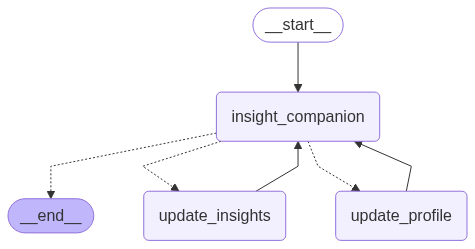

In [6]:
import uuid
from IPython.display import Image, display

from datetime import datetime
from trustcall import create_extractor
from typing import Optional
from pydantic import BaseModel, Field

from langchain_core.runnables import RunnableConfig
from langchain_core.messages import merge_message_runs, HumanMessage, SystemMessage

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, MessagesState, END, START
from langgraph.store.base import BaseStore
from langgraph.store.memory import InMemoryStore

from langchain_openai import ChatOpenAI

# Initialize the model
model = ChatOpenAI(model="gpt-4o", temperature=0)

# User profile schema
class Profile(BaseModel):
    """This is the profile of the user you are chatting with"""
    name: Optional[str] = Field(description="The user's name", default=None)
    location: Optional[str] = Field(description="The user's location", default=None)
    age: Optional[str] = Field(description="The user's age group", default=None)
    connections: list[str] = Field(
        description="Personal connection of the user, such as family members, friends, or coworkers",
        default_factory=list
    )
    interests: list[str] = Field(
        description="Interests and hobbies that the user has",
        default_factory=list
    )
    goals: list[str] = Field(
        description="Goals and aspirations that the user has",
        default_factory=list
    )
    preferences: list[str] = Field(
        description="Preferences that the user has",
        default_factory=list
    )
    notes: Optional[str] = Field(description="Notes about the user", default=None)

# Personal Insight schema
class PersonalInsight(BaseModel):
    """Hidden patterns or traits discovered about the user"""
    insight: str = Field(description="The discovered insight about user's personality, preferences, or patterns")
    evidence: list[str] = Field(
        description="When the task needs to be completed by (if applicable)",
        default=None
    )
    confidence: float = Field(description="Confidence level (0.0-1.0)", default=0.8)
    confirmed: bool = Field(description="Whether user has confirmed this insight", default=False)
    discovered_date: datetime = Field(default_factory=datetime.now)
    category: str = Field(description="Type of insight (e.g., 'personality', 'social', 'emotional', 'behavioral')")

# UpdateMemory tool
class UpdateMemory(BaseModel):
    update_type: Literal["user", "insight"] = Field(description="Type of memory to update")

# Create the Trustcall extractor for updating the user profile
profile_extractor = create_extractor(
    model,
    tools=[Profile],
    tool_choice="Profile",
)

# Chatbot instruction for Insight Generator
MODEL_SYSTEM_MESSAGE = """You are a thoughtful companion who helps young people discover insights about themselves.

Your role is to:
1. Listen carefully to what they share about their experiences
2. Notice patterns in their behavior, preferences, and reactions
3. Gently suggest insights about their personality or tendencies
4. Ask for their confirmation before saving insights
5. Help them understand themselves better

Here is the current User Profile (may be empty if no information has been collected yet):
<user_profile>
{user_profile}
</user_profile>

Here is the current Insight List (may be empty if no tasks have been added yet):
<insights>
{insights}
</insights>

Here are your instructions for reasoning about the user's messages:
Guidelines:
- Be gentle and supportive when suggesting insights
- Always ask "Does that sound right to you?" before assuming an insight is correct
- Look for patterns in their stories and experiences
- Focus on positive traits and growth opportunities
- Only save insights after they confirm them
- Be curious and encouraging

When you notice:
- New personal information → call UpdateMemory with type "user"
- User confirms an insight → call UpdateMemory with type "insight"

Example approach:
"I've noticed you seem to really enjoy activities where you can be creative and express yourself. Does that sound right to you?"

Respond naturally and supportively after updating memories."""

# Trustcall instruction
TRUSTCALL_INSTRUCTION = """Reflect on the following interaction.

Use the provided tools to retain any necessary memories about the user.

Focus on:
- Personal information and patterns
- Confirmed insights about their personality or behavior
- Evidence supporting these insights

Only save insights that the user has explicitly confirmed.

System Time: {time}"""

# Summary generation functions
def generate_profile_summary(new_data):
    """Generate friendly summary of profile updates"""
    summary = "📝 **I've learned more about you!**\n\n"

    if new_data.get('interests'):
        summary += f"🎯 Interests: {', '.join(new_data['interests'])}\n"

    if new_data.get('connections'):
        summary += f"👥 People in your life: {', '.join(new_data['connections'])}\n"

    if new_data.get('mood_patterns'):
        summary += f"💭 Mood patterns: {', '.join(new_data['mood_patterns'])}\n"

    summary += "\nThis helps me understand you better and notice meaningful patterns! ✨"
    return summary

def generate_insight_summary(insights_data):
    """Generate friendly summary of insight updates"""
    summary = "💡 **New Insight Saved!**\n\n"

    for insight in insights_data:
        insight_text = insight.get('insight', 'Unknown insight')
        category = insight.get('category', 'general')
        evidence = insight.get('evidence', [])

        summary += f"🔍 **{category.title()} Insight**: {insight_text}\n"

        if evidence:
            summary += f"📋 **Based on**: {', '.join(evidence[:3])}\n"  # Show first 3 pieces of evidence

        summary += f"✅ **Confirmed by you**\n\n"

    summary += "These insights help you understand yourself better! 🌟"
    return summary

# Node definitions
def insight_companion(state: MessagesState, config: RunnableConfig, store: BaseStore):
    """Main chatbot node for insight generation"""

    user_id = config["configurable"]["user_id"]

    # Retrieve profile
    namespace = ("profile", user_id)
    memories = store.search(namespace)
    user_profile = memories[0].value if memories else None

    # Retrieve insights
    namespace = ("insights", user_id)
    memories = store.search(namespace)
    insights = "\n".join(f"- {mem.value}" for mem in memories)

    system_msg = MODEL_SYSTEM_MESSAGE.format(
        user_profile=user_profile,
        insights=insights
    )

    response = model.bind_tools([UpdateMemory], parallel_tool_calls=False).invoke(
        [SystemMessage(content=system_msg)] + state["messages"]
    )

    return {"messages": [response]}

def update_profile(state: MessagesState, config: RunnableConfig, store: BaseStore):
    """Update user profile and provide summary"""

    user_id = config["configurable"]["user_id"]
    namespace = ("profile", user_id)

    existing_items = store.search(namespace)
    existing_memories = ([(existing_item.key, "Profile", existing_item.value)
                          for existing_item in existing_items]
                          if existing_items else None)

    TRUSTCALL_INSTRUCTION_FORMATTED = TRUSTCALL_INSTRUCTION.format(time=datetime.now().isoformat())
    updated_messages = list(merge_message_runs(
        messages=[SystemMessage(content=TRUSTCALL_INSTRUCTION_FORMATTED)] + state["messages"][:-1]
    ))

    result = profile_extractor.invoke({
        "messages": updated_messages,
        "existing": existing_memories
    })

    # Save and generate summary
    new_data = {}
    for r, rmeta in zip(result["responses"], result["response_metadata"]):
        new_data = r.model_dump(mode="json")
        store.put(namespace,
                  rmeta.get("json_doc_id", str(uuid.uuid4())),
                  new_data)

    summary = generate_profile_summary(new_data)

    tool_calls = state['messages'][-1].tool_calls
    return {"messages": [{"role": "tool", "content": summary, "tool_call_id": tool_calls[0]['id']}]}

def update_insights(state: MessagesState, config: RunnableConfig, store: BaseStore):
    """Update personal insights and provide summary"""

    user_id = config["configurable"]["user_id"]
    namespace = ("insights", user_id)

    existing_items = store.search(namespace)
    existing_memories = ([(existing_item.key, "PersonalInsight", existing_item.value)
                          for existing_item in existing_items]
                          if existing_items else None)

    TRUSTCALL_INSTRUCTION_FORMATTED = TRUSTCALL_INSTRUCTION.format(time=datetime.now().isoformat())
    updated_messages = list(merge_message_runs(
        messages=[SystemMessage(content=TRUSTCALL_INSTRUCTION_FORMATTED)] + state["messages"][:-1]
    ))

    insight_extractor = create_extractor(
        model,
        tools=[PersonalInsight],
        tool_choice="PersonalInsight",
        enable_inserts=True
    )

    result = insight_extractor.invoke({
        "messages": updated_messages,
        "existing": existing_memories
    })

    # Save and generate summary
    insights_data = []
    for r, rmeta in zip(result["responses"], result["response_metadata"]):
        insight_data = r.model_dump(mode="json")
        insight_data["confirmed"] = True  # Only save confirmed insights
        insights_data.append(insight_data)
        store.put(namespace,
                  rmeta.get("json_doc_id", str(uuid.uuid4())),
                  insight_data)

    summary = generate_insight_summary(insights_data)

    tool_calls = state['messages'][-1].tool_calls
    return {"messages": [{"role": "tool", "content": summary, "tool_call_id": tool_calls[0]['id']}]}

# Routing function
def route_message(state: MessagesState, config: RunnableConfig, store: BaseStore) -> Literal[END, "update_insights", "update_profile"]:
    """Route to appropriate update function"""
    message = state['messages'][-1]
    if len(message.tool_calls) == 0:
        return END
    else:
        tool_call = message.tool_calls[0]
        if tool_call['args']['update_type'] == "user":
            return "update_profile"
        elif tool_call['args']['update_type'] == "insight":
            return "update_insights"
        else:
            raise ValueError

# Build graph
builder = StateGraph(MessagesState)
builder.add_node("insight_companion", insight_companion)
builder.add_node("update_insights", update_insights)
builder.add_node("update_profile", update_profile)
builder.add_edge(START, "insight_companion")
builder.add_conditional_edges("insight_companion", route_message)
builder.add_edge("update_insights", "insight_companion")
builder.add_edge("update_profile", "insight_companion")

# Compile graph
across_thread_memory = InMemoryStore()
within_thread_memory = MemorySaver()
insight_generator_graph = builder.compile(checkpointer=within_thread_memory, store=across_thread_memory)

print("🧠 Personal Insight Generator Ready!")
display(Image(insight_generator_graph.get_graph(xray=1).draw_mermaid_png()))

In [9]:
# Test the insight system
config = {"configurable": {"user_id": "test_user_2", "thread_id": "test_thread_1"}}

for chunk in insight_generator_graph.stream(
    {"messages": [HumanMessage(content="I always feel more energized when I'm around people rather than alone")]},
    config=config
):
    print(chunk)

{'insight_companion': {'messages': [AIMessage(content='It sounds like you might gain energy from being around others, which is a common trait of extroversion. Does that sound right to you?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 30, 'prompt_tokens': 335, 'total_tokens': 365, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_a288987b44', 'id': 'chatcmpl-Bs7WOI2jSyx9JHbS1mPCN9YN9D0yc', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--9b0c8250-f515-4a5f-bca5-fe816db57a9e-0', usage_metadata={'input_tokens': 335, 'output_tokens': 30, 'total_tokens': 365, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})]}}


We can see that Trustcall performs patching of the existing memory:

https://smith.langchain.com/public/4ad3a8af-3b1e-493d-b163-3111aa3d575a/r

Trace:

https://smith.langchain.com/public/84768705-be91-43e4-8a6f-f9d3cee93782/r